# Continuous Photobleaching (CP)

### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import center_of_mass
from skimage import io, filters
from skimage.util import img_as_ubyte
from skimage.transform import rotate
from slb import IntensityCurve
from tifffile import imsave

### Determine the directory and the movie

In [2]:
# Names
directory = '20211124_GUV_on_SOPC_Ecad'
stack     = 'movie-600-fast3'

# Parameters
dt, dx = 0.1, 0.125
start  = 0

### Read the movie stack and display average and histogram.

Data shape = (600, 1002, 1004)
The baseline removed = 9.0


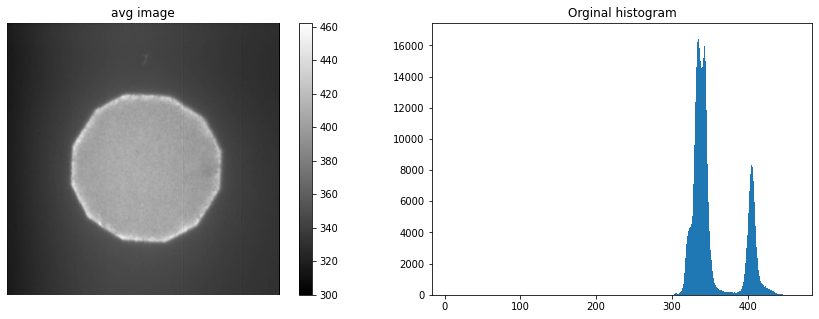

In [3]:
# Read the movie movie
movie = io.imread(f"data/{directory}/data/{stack}.tif")[start:].astype(np.float64)
#movie = io.imread(f"data/{directory}/data/{stack}.tif")[start:, 180:-110, 160:-150].astype(np.float64)

# Determin the ending frame
end = start+movie.shape[0]

# Print the dimension of the movie
print(f'Data shape = {movie.shape}')

# Remove the baseline
print(f'The baseline removed = {movie.min()}')
movie -= movie.min()

# Save the movie
imsave(f"data/{directory}/results/{stack}_{start}_{end}.tif", movie)

# display the average and it's histogram
plt.figure(figsize=(15,5))

# Average the movie
avg = np.mean(movie, axis=0)

plt.subplot(121)
plt.axis('off')
plt.title('avg image')
plt.imshow(avg, cmap = "gray", vmin=300)
plt.colorbar();

plt.subplot(122)
plt.title('Orginal histogram')
plt.hist(avg.ravel(), bins = 1000);
#plt.xlim(300,800);

### Display the Begining and the End of the stack with better contrast

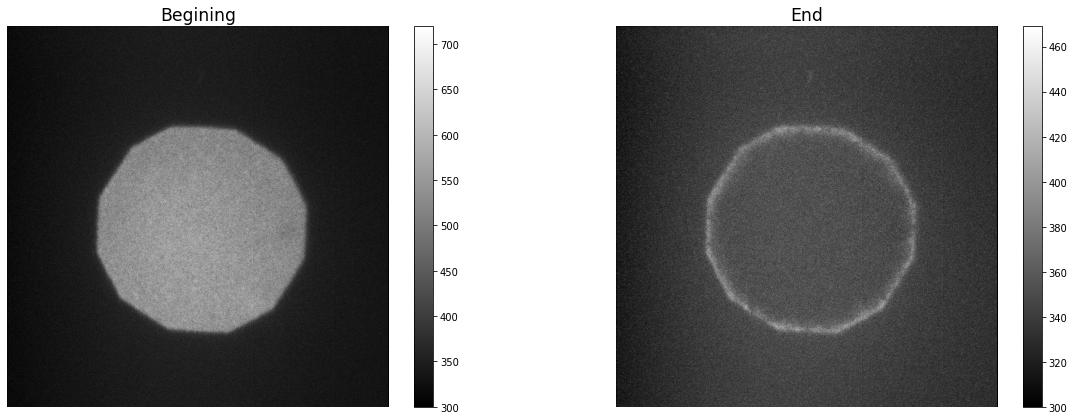

In [4]:
# Average over the starting and ending few frames
avg_start = movie[:10].mean(axis = 0)
avg_end   = movie[-10:].mean(axis = 0)

# Display the image with better brightness and contrast
plt.figure(figsize=(20,7))

plt.subplot(121)
plt.axis('off')
plt.title('Begining', fontsize='xx-large')
plt.imshow(avg_start, cmap = "gray", vmin=300)
plt.colorbar();

plt.subplot(122)
plt.axis('off')
plt.title('End'     , fontsize='xx-large')
plt.imshow(avg_end  , cmap = "gray", vmin=300)
plt.colorbar();

plt.savefig(f'data/{directory}/results/{stack}_Begining_and_END.png')

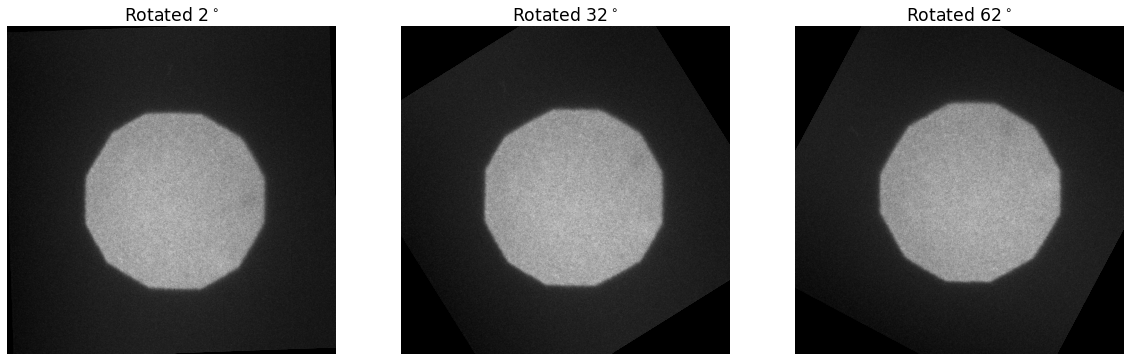

In [5]:
# Choose the set of ratations
rotations = [2, 32 , 62]

# Display the first image with rotaion 30 and 60 degree
plt.figure(figsize=(20,7))

for i, th in enumerate(rotations):
    plt.subplot(1,3,i+1)
    plt.axis('off')
    plt.title(f'Rotated {th}$^\circ$', fontsize='xx-large')
    plt.imshow(rotate(avg_start, th), cmap = "gray", vmin=300)
    
plt.savefig(f'data/{directory}/results/{stack}_{start}_{end}_Rotations')

### Measure the radius and the center on the diaphragm to Determine the ROIs

Rotation = 2 degree
Radius = 279
Center = [533 512]

Rotation = 32 degree
Radius = 279
Center = [523 527]

Rotation = 62 degree
Radius = 279
Center = [507 535]



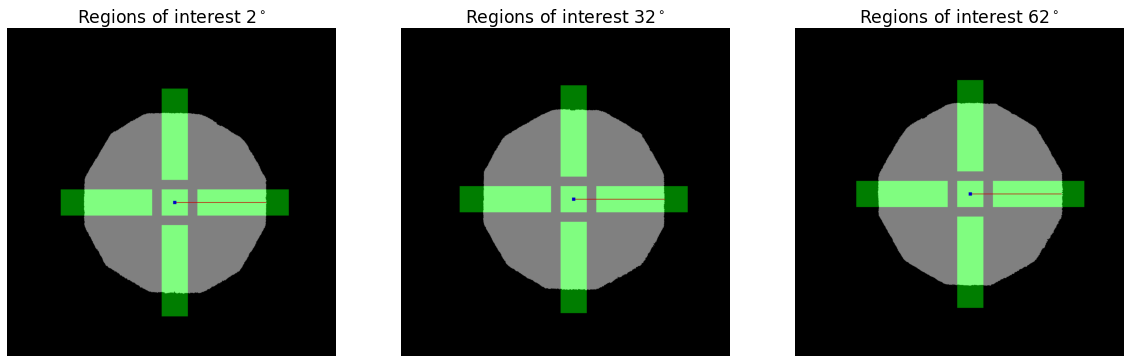

In [6]:
# Getting the threshold of edge filtered image
threshold = filters.threshold_otsu(avg)

# Making a binary mask image with 0 and 1 values
masks = [np.multiply(rotate(avg, th) > threshold, 1, dtype=float) for th in rotations]

# Display the regions in with rotaion 30 and 60 degree
plt.figure(figsize=(20,7))

for i, (mask, th) in enumerate(zip(masks, rotations)):
    
    # Measure the radius of the diaphragm by treating it as a circle with area = Pi*R^2
    radius = int(np.sqrt(np.sum(mask)/(np.pi)))

    # Determine the center of mass for the mask and transform it into integer array.
    center = np.array(center_of_mass(mask)).astype(int)

    print(f'Rotation = {th} degree\nRadius = {radius}\nCenter = {center}\n')

    # Get an RGB copy of the mask
    umask = img_as_ubyte(np.tensordot(mask, np.array([0.5, 0.5, 0.5]), axes=0))
    
    ## Draw the regions to be measured
    
    # Rectangle center
    umask[center[0]-40:center[0]+40, center[1]-40:center[1]+40] += img_as_ubyte([0,0.49,0])
    
    # Rectangle right
    umask[center[0]-40:center[0]+40, center[1]+int(radius/4):center[1]+int(radius*5/4)] += img_as_ubyte([0,0.49,0])
    # Rectangle left
    umask[center[0]-40:center[0]+40, center[1]-int(radius*5/4):center[1]-int(radius/4)] += img_as_ubyte([0,0.49,0])
    # Rectangle up
    umask[center[0]-int(radius*5/4):center[0]-int(radius/4), center[1]-40:center[1]+40] += img_as_ubyte([0,0.49,0])
    # Rectangle down
    umask[center[0]+int(radius/4):center[0]+int(radius*5/4), center[1]-40:center[1]+40] += img_as_ubyte([0,0.49,0])

    # Draw the radius of the mask
    umask[center[0]-1:center[0]+1, center[1]:center[1]+radius] = [200,0,0]
    # Draw the center of the mask
    umask[center[0]-5:center[0]+5, center[1]-5:center[1]+5]    = [0,0,200]
    
    
    # plot the regions of interest
    plt.subplot(1,3,i+1)
    plt.axis('off')
    plt.title(f'Regions of interest {th}$^\circ$', fontsize='xx-large')
    plt.imshow(umask);

# Save the image
plt.savefig(f'data/{directory}/results/{stack}_{start}_{end}_Regions_of_interest')

### Fit the Intensity curves on the Intensity equations to get the diffusion constant:
Intensity equation of time

$I(t) = I_0 e^{(-Bt)} + I_{b}$

Intensity equation of space

$I(x) = I_0 e^{-x \sqrt{B/D}} + I_{b}$

where $I_0 , I_{b}, B, D$ are fitting parameters.

$I_0$: Initial intensity

$I_{b}$: Background intensity

$B$: Bleaching rate of the fluorophores

$D$: Diffusion constant

### Extract the curves of the ROIs

In [7]:
# Compute the curves of the regoins of interest for the three rotations
rectangle_center, rectangle_right, rectangle_left, rectangle_up, rectangle_down = [], [], [], [], []
for th in rotations:
    
    movie_th = np.array([rotate(img, th) for img in movie])
    
    # Take the average of the center to get I(t)
    rectangle_center.append(np.mean(movie_th[:,center[0]-40:center[0]+40, center[1]-40:center[1]+40], axis=(1,2)))
    
    # Take the mean over the short edge and last 10 frames of each rectangle to get it's Ix curve 
    # Then reverse the right and the down rectangles curve
    rectangle_right.append(np.mean(movie_th[-20:,center[0]-40:center[0]+40, center[1]+int(radius/4):center[1]+int(radius*5/4)], axis=(0,1))[::-1])
    rectangle_left.append(np.mean(movie_th[-20:,center[0]-40:center[0]+40, center[1]-int(radius*5/4):center[1]-int(radius/4)], axis=(0,1)))
    rectangle_up.append(np.mean(movie_th[-20:,center[0]-int(radius*5/4):center[0]-int(radius/4), center[1]-40:center[1]+40], axis=(0,2)))
    rectangle_down.append(np.mean(movie_th[-20:,center[0]+int(radius/4):center[0]+int(radius*5/4), center[1]-40:center[1]+40], axis=(0,2))[::-1])

# Transform them into numpy arrays
rectangle_center = np.array(rectangle_center)
rectangle_right  = np.array(rectangle_right)
rectangle_left   = np.array(rectangle_left)
rectangle_up     = np.array(rectangle_up)
rectangle_down   = np.array(rectangle_down)

### Draw all the curves

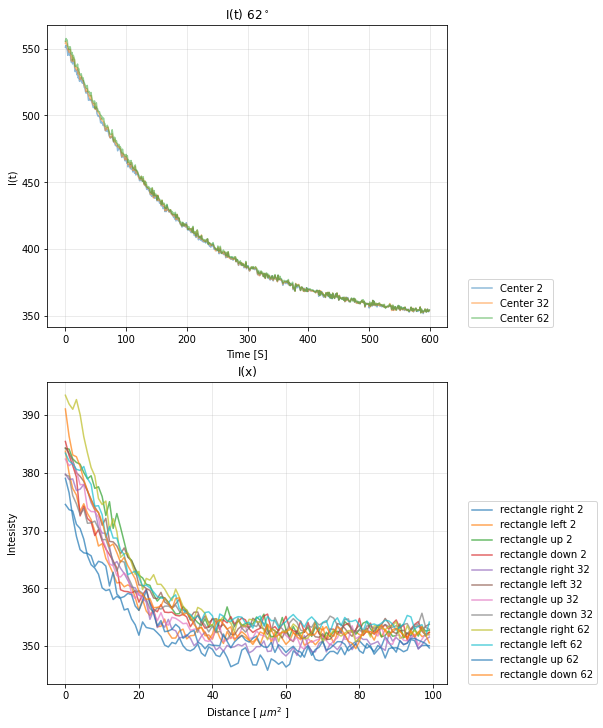

In [8]:
# Display the results
plt.subplots(2,1, figsize=(8.27,10), constrained_layout=True)

plt.subplot(211)
for i, th in enumerate(rotations):
    plt.plot(rectangle_center[i], label=f'Center {th}', alpha = 0.5)

plt.title(f'I(t) {th}$^\circ$')
plt.xlabel('Time [S]')
plt.ylabel('I(t)')
plt.grid(alpha = 0.3)
plt.legend(loc=(1.05, 0))

plt.subplot(212)
for i, th in enumerate(rotations):
    plt.plot(rectangle_right[i][rectangle_right[i].argmax():][:100], label=f'rectangle right {th}', alpha = 0.7)
    plt.plot(rectangle_left [i][rectangle_left[i].argmax() :][:100], label=f'rectangle left {th}' , alpha = 0.7)
    plt.plot(rectangle_up   [i][rectangle_up[i].argmax()   :][:100], label=f'rectangle up {th}'   , alpha = 0.7)
    plt.plot(rectangle_down [i][rectangle_down[i].argmax() :][:100], label=f'rectangle down {th}' , alpha = 0.7)

plt.title(f'I(x)')
plt.xlabel('Distance [ $\mu m^2$ ]')
plt.ylabel('Intesisty')
plt.grid(alpha = 0.3)
plt.legend(loc=(1.05, 0));

plt.savefig(f'data/{directory}/results/{stack}_{start}_{end}_Regoins_curves')

### Fit the intensity equations of time and space on the data

Intensity equation of time:
Io = 210.396
Ib = 344.652
B = 0.054

Intensity equation of space:
Io = 35.049
Ib = 349.643
D = 0.222



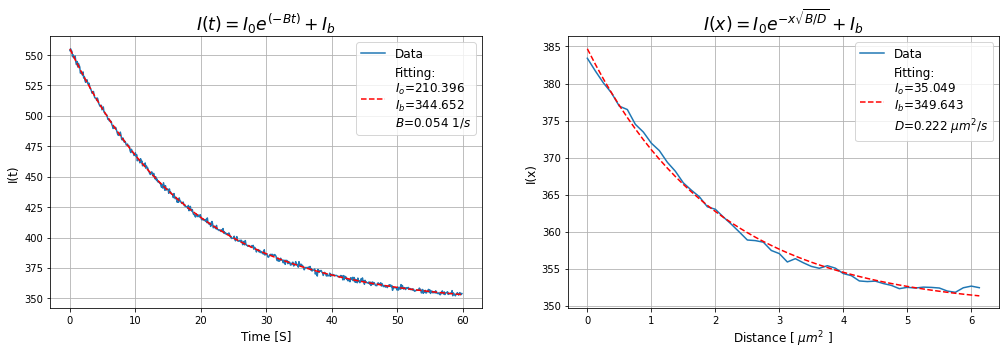

In [9]:
# Take the average of the centers to get I(t)
It = np.mean([rectangle_center[0], rectangle_center[1], rectangle_center[2]], axis=0)

# Take the average of the rectangles to get I(x)
Ix = np.mean([rectangle[rectangle.argmax():][:50] for rectangle in 
              [rectangle_right[0], rectangle_left[0], rectangle_up[0], rectangle_down[0],
               rectangle_right[1], rectangle_left[1], rectangle_up[1], rectangle_down[1],
               rectangle_right[2], rectangle_left[2], rectangle_up[2], rectangle_down[2]]],
             axis=0)

# Arange the time and space according to the microscope parameters
t  = np.arange(movie.shape[0]) * dt
x  = np.arange(Ix.shape[0]) * dx


# Fit the curves and
It_curve = IntensityCurve(t, x, It, Ix)
B, Io_t, Ib_t, D, Io_x, Ib_x = It_curve.curve_fitting()

# Print the parameters
print(f'Intensity equation of time:\nIo = {Io_t:.3f}\nIb = {Ib_t:.3f}\nB = {B:.3f}\n')
print(f'Intensity equation of space:\nIo = {Io_x:.3f}\nIb = {Ib_x:.3f}\nD = {D:.3f}\n')

# Display the results
plt.figure(figsize=(17,5))

# Intensity time curve
plt.subplot(121)
plt.plot(t, It, label='Data')
plt.plot(t, Io_t * np.exp(-B*t) + Ib_t, "r--",
         label =f'Fitting:\n$I_o$={Io_t:.3f}\n$I_b$={Ib_t:.3f}\n$B$={B:.3f} $1/s$')
plt.title('$I(t) = I_0 e^{(-Bt)} + I_{b}$', fontsize='xx-large')
plt.xlabel('Time [S]', fontsize='large')
plt.ylabel('I(t)', fontsize='large')
plt.grid()
plt.legend(fontsize='large')

# Intensity space curve
plt.subplot(122)
plt.plot(x, Ix, label='Data')
plt.plot(x, Io_x * np.exp(-x*np.sqrt(B/D)) + Ib_x, "r--",
         label =f'Fitting:\n$I_o$={Io_x:.3f}\n$I_b$={Ib_x:.3f}\n$D$={D:.3f} $\mu m^2/s$')
plt.title('$I(x) = I_0 e^{-x \sqrt{B/D}} + I_{b}$', fontsize='xx-large')
plt.xlabel('Distance [ $\mu m^2$ ]', fontsize='large')
plt.ylabel('I(x)', fontsize='large')
plt.grid()
plt.legend(fontsize='large');

# Save the figure
plt.savefig(f'data/{directory}/results/{stack}_{start}_{end}_D={D:.3f}.pdf')
plt.savefig(f'data/{directory}/results/{stack}_{start}_{end}_D={D:.3f}.png')